# TVB-ANNarchy: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## Izhikevich Spiking network model in ANNarchy

For every neuron $i$ in region node $n$ modelled in ANNarchy as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C $

$\;\;\;\;\;\;\;- g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e $

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_annarchy.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_annarchy")[0], "data/basal_ganglia")
fit_data_path = os.path.join(data_path, "ANNarchyFittedModels/dataFits_2020_02_05/databestfits", )
data_mode = "patient" # "control" "patient"
control_data = os.path.join(fit_data_path, "controlleft/OutputSim_Patient08.mat")
patient_data = os.path.join(fit_data_path, "patientleft/OutputSim_Patient09.mat")
if data_mode == "patient":
    subject_data = patient_data
else:
    subject_data = control_data
    
simulation_mode = "stim" # "stim" # "rs"
simulation_length = 1500.0
transient = 500.0 # simulation_length/11
start_stimulus = 100.0

noise = 2.0
stim_mode = "bi" # "bi", "mono", "simple"
stim_freq = 155.0 # 160.0 # for bi,  160.0 for mono, 0.0 for simple
stim_ampl = 20.0 # -35.0 # for STN (bi and mono), 50.0 for STN simple, and -5.0 for GPi simple
stim_duration = 0.3 # 
stim_target = "STN"  # "GPi"
if simulation_mode == "stim":
    simulation_mode = simulation_mode + "_%s_%s" % (stim_target, stim_mode)
#     if noise > 0.0:
#         simulation_mode += "_n%g" % noise
outputs_path = os.path.join(work_path, "outputs/outputs_Izhikevich_annarchy")
sim_mode_path = os.path.join(outputs_path, "SpikingCortex", data_mode, simulation_mode)
config = Config(output_base=sim_mode_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

Region labels:
['GPe_Left' 'GPi_Left' 'STN_Left' 'Striatum_Left' 'Thal_Left' 'Cortex']
{'dSNGPi_probs': 0.17859516634489409, 'dSNGPi_weights': 0.008694033162319101, 'iSNGPe_probs': 0.33518908071564507, 'iSNGPe_weights': 0.008090356577449711, 'GPeSTN_probs': 0.16505628454033283, 'GPeSTN_weights': 0.005997084264236037, 'STNGPe_probs': 0.3962228806747589, 'STNGPe_weights': 0.011259651579748606, 'STNGPi_probs': 0.24895916907698845, 'STNGPi_weights': 0.012728955057755228, 'GPeGPi_probs': 0.3252567500370787, 'GPeGPi_weights': 0.006170218545084936, 'GPeGPe_probs': 0.32325378120003734, 'GPeGPe_weights': 0.006765628813882359, 'GPiGPi_probs': 0.3371743973897537, 'GPiGPi_weights': 0.01216071144597663, 'GPiThal_probs': 0.24578932343574705, 'GPiThal_weights': 0.007014219544362278, 'ThaliSN_probs': 0.13343960522906853, 'ThaliSN_weights': 0.005992356203860255, 'ThaldSN_probs': 0.12055055752571203, 'ThaldSN_weights': 0.012069912539882353, 'dSNdSN_probs': 0.43455099617713133, 'dSNdSN_weights': 0.007630

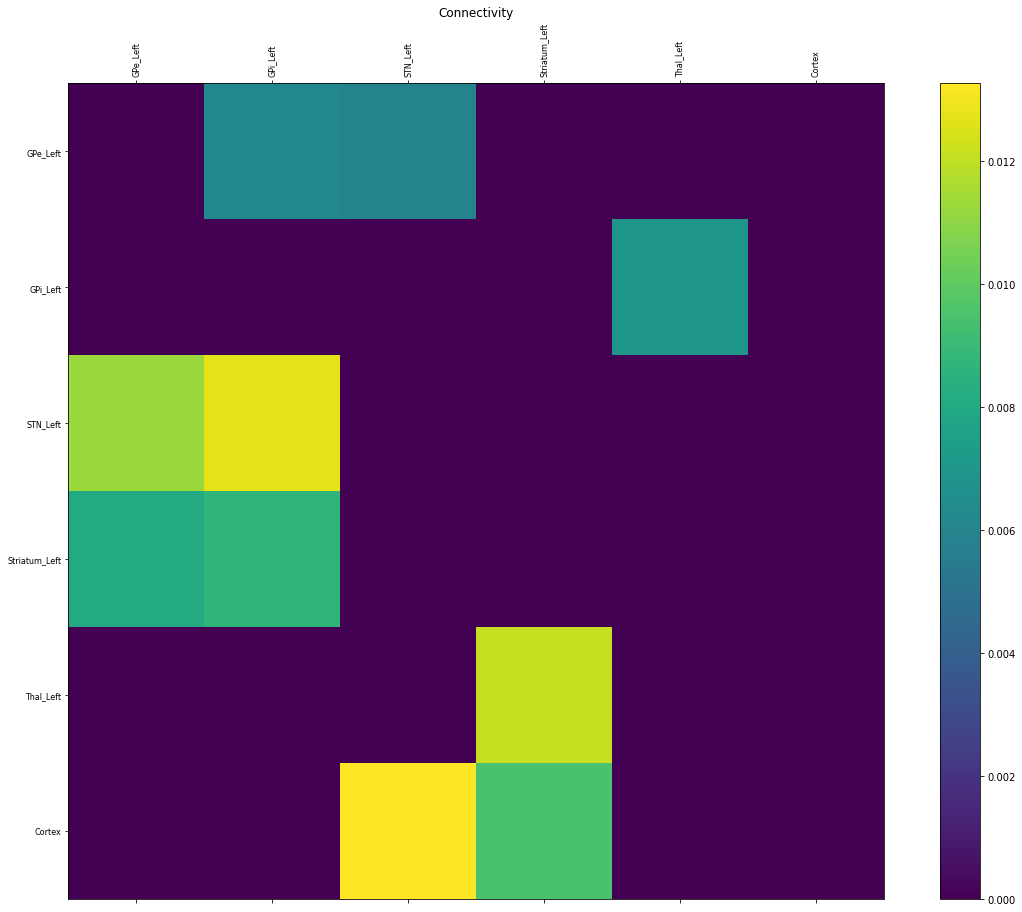

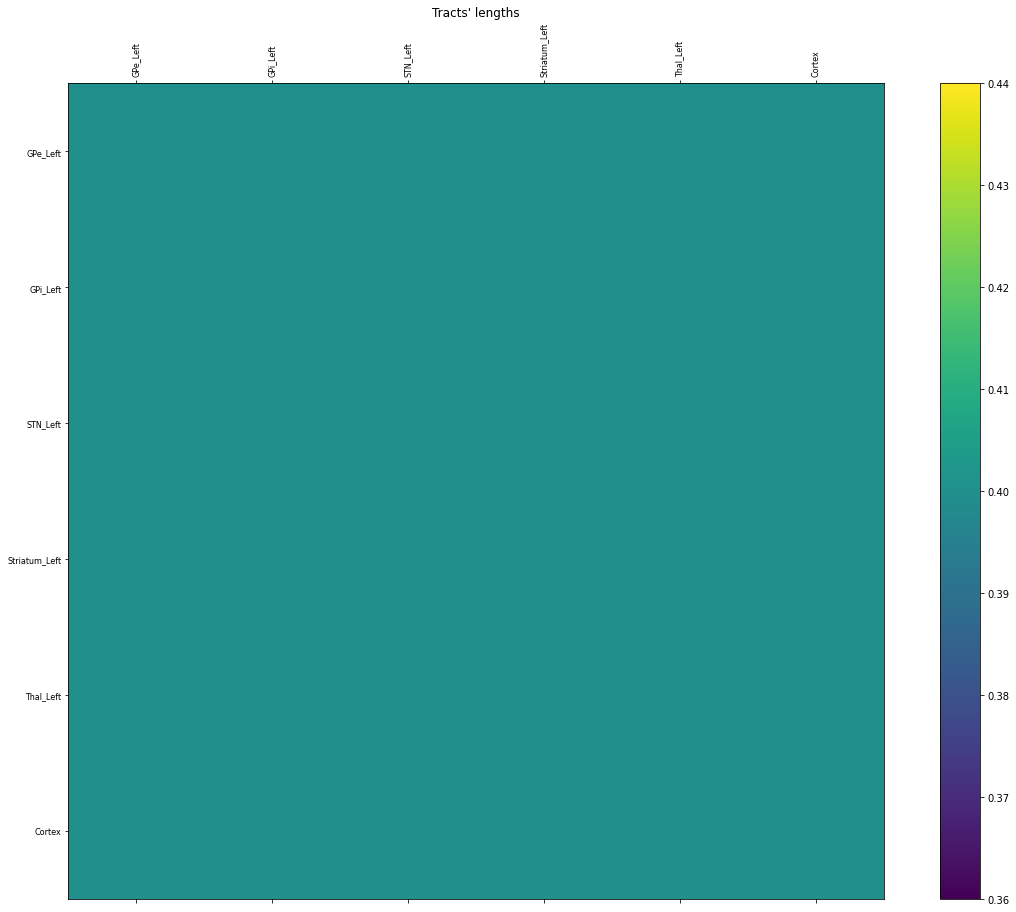

In [2]:
from tvb_multiscale.core.tvb.cosimulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial import CoSimulatorSerial as CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG
    

conn_path = os.path.join(data_path, "conn_incl_cortex")

w = np.zeros((11,11))
c=np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers_incl_cortex.txt"), usecols=range(1,3))
rl= np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers_incl_cortex.txt"), dtype="str", usecols=(0,))
t= np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths_incl_cortex.txt"))

# Keep only the BG and a single Cortex node:
c = c[:11]
rl = rl[:11]
rl[10] = "Cortex"
w = w[:11][:, :11]
t = t[:11][:, :11]

# Keep only left hemisphere and the Cortex:
inds = np.arange(0,10,2).astype("i").tolist() + [10]
c = c[inds] 
rl = rl[inds]
print("Region labels:\n%s" % rl)
# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left, 5. Cortex
w = w[inds][:, inds]
t = t[inds][:, inds]

# % loadedParams ={
# %     	'D1GPi_probs': probs[0],
# %     	'D1GPi_weights'  : weights[0],
# %     	'D2GPe_probs'   : probs[1],
# %     	'D2GPe_weights'  : weights[1],
# %     	'GPeSTN_probs'   : probs[2],
# %     	'GPeSTN_weights'  : weights[2],
# %     	'STNGPe_probs'   : probs[3],
# %     	'STNGPe_weights'  : weights[3],
# %     	'STNGPi_probs'   : probs[4],
# %     	'STNGPi_weights' : weights[4],
# %     	'GPeGPi_probs'   : probs[5],
# %     	'GPeGPi_weights'  : weights[5],
# %     	'GPeGPe_probs'   : probs[6],
# %     	'GPeGPe_weights'  : weights[6],
# %     	'GPiGPi_probs'   : probs[7],
# %     	'GPiGPi_weights'  : weights[7],
# %     	'GPiThal_probs'   : probs[8],
# %     	'GPiThal_weights'  : weights[8],
# %     	'ThaliSN_probs'   : probs[9],
# %     	'ThaliSN_weights'  : weights[9],
# %     	'ThaldSN_probs'   : probs[10],
# %     	'ThaldSN_weights'  : weights[10],
# %     	'dSNdSN_probs'   : probs[11],
# %     	'dSNdSN_weights'  : weights[11],
# %     	'iSNiSN_probs'   : probs[12],
# %     	'iSNiSN_weights'  : weights[12],
# %     	'CdSN_probs'   : probs[13],
# %     	'CdSN_weights'  : weights[13],
# %     	'CiSN_probs'   : probs[14],
# %     	'CiSN_weights'  : weights[14],
# %     	'CSTN_probs'   : probs[15],
# %     	'CSTN_weights'  : weights[15],
# %     	'V1Inh_probs'    : probs[16],
# %     	'V1Inh_weights'  : weights[16],
# %     	'InhV1_probs'    : probs[17],
# %     	'InhV1_weights'  : weights[17],
# %     	'InhInh_probs'   : probs[18],
# %     	'InhInh_weights'  : weights[18]}

# dSN = dSN, iSN = iSN from now on

# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left
BG_opt_matrix_weights = np.zeros((5, 5))
conn_mode = "subject" # "average"
if conn_mode == "average":
    weights_maith = np.array([1.93, 3.56, 1.46, 4.51, 3.52, 2.30, 2.34, 3.78, 1.98, 
                             1.30, 1.82, 3.56, 3.02, 1.78, 1.36, 2.27, 4.13, 2.74, 3.27])*1e-3  # controls
#     weights_maith = np.array([3.27, 3.80, 2.65, 3.66, 3.06, 3.06, 3.25, 4.02, 3.32, 
#                             2.98, 3.45, 3.64, 2.50, 2.12, 2.86, 2.79, 3.96, 3.69, 3.87])*1e-3   # patients
    # probs_maith = ????
else:
    import scipy.io as sio
    weights=sio.loadmat(subject_data) # weights start from index 19
    weights_maith = weights["X"][0, 19:] # these are indices 19 till 37
    probs_maith = weights["X"][0, :19] # these are indices 0 till 18

wdSNGPi = BG_opt_matrix_weights[3, 1] = weights_maith[0]
wiSNGPe = BG_opt_matrix_weights[3, 0] = weights_maith[1]
wGPeSTN = BG_opt_matrix_weights[0, 2] = weights_maith[2]
wSTNGPe = BG_opt_matrix_weights[2, 0] = weights_maith[3]
wSTNGPi = BG_opt_matrix_weights[2, 1] = weights_maith[4]
wGPeGPi = BG_opt_matrix_weights[0, 1] = weights_maith[5]  
wGPiTh = BG_opt_matrix_weights[1, 4] = weights_maith[8]
wThdSN = BG_opt_matrix_weights[4, 3] = weights_maith[10] # Th -> dSN
    
sliceBGnet = slice(0,5)
w[sliceBGnet, sliceBGnet] = BG_opt_matrix_weights

wGPeGPe = weights_maith[6]   # "GPe" -> "GPe" 
wGPiGPi = weights_maith[7]   # "GPi" -> "GPi" 
wThiSN = weights_maith[9]    # "Eth" -> "IiSN" 

wdSNdSN = weights_maith[11]  # "IdSN" -> "IdSN" 
wiSNiSN = weights_maith[12]  # "IiSN" -> "IiSN" 
wCtxdSN = w[5, 3] = weights_maith[13]  # "CxE" -> "IdSN" 
wCtxiSN = weights_maith[14] # "CxE" -> "IiSN" 
wCtxSTN = w[5, 2] = weights_maith[15]  # "CxE" -> "Estn"
wCtxEtoI = weights_maith[16] # "CxE" -> "CxI"
wCtxItoE = weights_maith[17] # "CxI" -> "CxE"
wCtxItoI = weights_maith[18] # "CxI" -> "CxI"

pdSNGPi = probs_maith[0]
piSNGPe = probs_maith[1]
pGPeSTN = probs_maith[2]
pSTNGPe = probs_maith[3]
pSTNGPi = probs_maith[4]
pGPeGPi = probs_maith[5]  
pGPeGPe = probs_maith[6]  # "GPe" -> "GPe" 
pGPiGPi = probs_maith[7]  # "GPi" -> "GPi" 
pGPiTh = probs_maith[8]
pThiSN =  probs_maith[9]  # "Eth" -> "IiSN
pThdSN = probs_maith[10] # Th --> dSN
pdSNdSN = probs_maith[11] # "IdSN" -> "IdSN" 
piSNiSN = probs_maith[12] # "IiSN" -> "IiSN" 
pCtxdSN = probs_maith[13]  # "CxE" -> "IdSN" 
pCtxiSN = probs_maith[14] # "CxE" -> "IiSN" 
pCtxSTN = probs_maith[15]  # "CxE" -> "Estn"
pCtxEtoI = probs_maith[16] # "CxE" -> "CxI"
pCtxItoE = probs_maith[17] # "CxI" -> "CxE"
pCtxItoI = probs_maith[18] # "CxI" -> "CxI"
    
loadedParams ={'dSNGPi_probs': probs_maith[0],
    	'dSNGPi_weights'  : weights_maith[0],
    	'iSNGPe_probs'   : probs_maith[1],
    	'iSNGPe_weights'  : weights_maith[1],
    	'GPeSTN_probs'   : probs_maith[2],
    	'GPeSTN_weights'  : weights_maith[2],
    	'STNGPe_probs'   : probs_maith[3],
    	'STNGPe_weights'  : weights_maith[3],
    	'STNGPi_probs'   : probs_maith[4],
    	'STNGPi_weights' : weights_maith[4],
    	'GPeGPi_probs'   : probs_maith[5],
    	'GPeGPi_weights'  : weights_maith[5],
    	'GPeGPe_probs'   : probs_maith[6],
    	'GPeGPe_weights'  : weights_maith[6],
    	'GPiGPi_probs'   : probs_maith[7],
    	'GPiGPi_weights'  : weights_maith[7],
    	'GPiThal_probs'   : probs_maith[8],
    	'GPiThal_weights'  : weights_maith[8],
    	'ThaliSN_probs'   : probs_maith[9],
    	'ThaliSN_weights'  : weights_maith[9],
    	'ThaldSN_probs'   : probs_maith[10],
    	'ThaldSN_weights'  : weights_maith[10],
    	'dSNdSN_probs'   : probs_maith[11],
    	'dSNdSN_weights'  : weights_maith[11],
    	'iSNiSN_probs'   : probs_maith[12],
    	'iSNiSN_weights'  : weights_maith[12],
    	'CtxdSN_probs'   : probs_maith[13],
    	'CtxdSN_weights'  : weights_maith[13],
    	'CtxiSN_probs'   : probs_maith[14],
    	'CtxiSN_weights'  : weights_maith[14],
    	'CtxSTN_probs'   : probs_maith[15],
    	'CtxSTN_weights'  : weights_maith[15],
    	'CtxECtxI_probs'    : probs_maith[16],
    	'CtxECtxI_weights'  : weights_maith[16],
    	'CtxICtxE_probs'    : probs_maith[17],
    	'CtxICtxE_weights'  : weights_maith[17],
    	'CtxICtxI_probs'   : probs_maith[18],
    	'CtxICtxI_weights'  : weights_maith[18],
        'CtxThal_weights': 0.0,
        'CtxThal_probs': 1.0}
print(loadedParams)

assert_loadedParams = dict(zip(loadedParams.values(), loadedParams.keys()))

# Finally form the TVB Connectivity
dt = 0.1
speed = 4.0
delays = False
if not delays:
    t = dt * speed * np.ones(t.shape)
connectivity=Connectivity(region_labels=rl, weights=w, centres=c, tract_lengths=t)

# Normalize connectivity weights
# connectivity.weights = connectivity.scaled_weights(mode="region")
# connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0
connectivity.speed = np.array([speed])
connectivity.configure()

#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = dt
simulator.integrator.noise.nsig = np.array([0.001])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the ANNarchy network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [3]:
from tvb_multiscale.tvb_annarchy.annarchy_models.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder
from tvb_multiscale.tvb_annarchy.annarchy.models import Izhikevich_Hamker

# Select the regions for the fine scale modeling with ANNarchy spiking networks
#including cortex node:
spiking_nodes_ids = [0, 1, 2, 3, 4, 5]  # the indices of fine scale regions modeled with ANNarchy

# Build a ANNarchy network model with the corresponding builder
ann_model_builder = BasalGangliaIzhikevichBuilder(simulator, spiking_nodes_ids, config=config)



# Using all default parameters for this example


# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = Izhikevich_Hamker

ann_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

ann_model_builder.params_common = \
    {"v": -70.0, "u": -18.55, "E_ampa": 0.0, "E_gaba": -90.0, "v_th": 30.0, "Vr": 0.0, "c": -65.0,
     "C": 1.0, "I": 0.0,
     "tau_syn": 1.0, "tau_ampa": 10.0, "tau_gaba": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04, 
     "v": -72.0, "u": -14.0, 
     "noise": 0.0}

ann_model_builder._paramsI = deepcopy(ann_model_builder.params_common)
ann_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0, 
                                   "v": -70.0, "u": -18.55})
ann_model_builder._paramsE = deepcopy(ann_model_builder.params_common)
ann_model_builder._paramsE.update({"v": -70.0, "u": -18.55})
ann_model_builder.paramsStr = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr.update({"v_th": 40.0, "C": 50.0, "Vr": -80.0,
                                    "n0": 61.65119, "n1": 2.594639, "n2": 0.022799, 
                                    "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0, 
                                    "v": -70.0, "u": -18.55})

ann_model_builder.Igpe_nodes_ids = [0]
ann_model_builder.Igpi_nodes_ids = [1]
ann_model_builder.Estn_nodes_ids = [2]
ann_model_builder.Eth_nodes_ids = [4]
ann_model_builder.Istr_nodes_ids = [3]
#including cortex node:
ann_model_builder.Crtx_nodes_ids = [5]

I_nodes_ids = ann_model_builder.Igpe_nodes_ids + ann_model_builder.Igpi_nodes_ids + ann_model_builder.Crtx_nodes_ids
E_nodes_ids = ann_model_builder.Estn_nodes_ids + ann_model_builder.Eth_nodes_ids + ann_model_builder.Crtx_nodes_ids


def paramsE_fun(node_id, cortex_noise=noise):
    paramsE = deepcopy(ann_model_builder._paramsE)
    if node_id in ann_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I": 3.0})  # dictionary of params for Estn
    elif node_id in ann_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I": 3.5}) # dictionary of params for Eth
    elif node_id in ann_model_builder.Crtx_nodes_ids:
        paramsE.update({"v": -72.0, "u": -14.0, 
                        "a": 0.02, "b": 0.2, "d": 6.0,"c": -72.0, 
                        "I": 7.0, }) # 50.0 dictionary of params for CortexExcitatory
        if cortex_noise > 0.0:
            paramsE.update({"noise": cortex_noise*paramsE["I"]})
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(ann_model_builder._paramsI)
    if node_id in ann_model_builder.Igpe_nodes_ids:
        paramsI.update({"I": 12.0})
    elif node_id in ann_model_builder.Igpi_nodes_ids:
        paramsI.update({"I": 30.0})
    elif node_id in ann_model_builder.Crtx_nodes_ids:
        paramsI.update({"v": -72.0, "u": -14.0, 
                        "c": -72.0,"a": 0.02, "b": 0.2, "d": 6.0, 
                        "I_e": 0.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
ann_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4], Cortex in [5]
     "scale": lambda node_id: 3.0 if node_id in ann_model_builder.Crtx_nodes_ids else 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1], Cortex in [5]
     "scale": lambda node_id: 0.75 if node_id in ann_model_builder.Crtx_nodes_ids else 1.0},
    {"label": "IdSN", "model": population_neuron_model,   
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

synapse_model = "DefaultSpikingSynapse"
conn_spec = {'rule': "all_to_all", 
             "allow_self_connections": True, "force_multiple_weights": False}
conn_spec_fixed_probability = conn_spec.copy()
conn_spec_fixed_probability.update({'rule': "fixed_probability", "probability": 0.1})

def conn_spec_fixed_prob(prob=None):
    output = conn_spec_fixed_probability.copy()
    if prob is not None:
        output["probability"] = prob
    return output

within_node_delay = 1.0
        

# for each connection, we have a different probability
ann_model_builder.populations_connections = [
     #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "CxI"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pCtxItoI),  # conn_spec
     "weight": np.abs(wCtxItoI), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Crtx_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPe),  # conn_spec
     "weight": np.abs(wGPeGPe), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiGPi),  # conn_spec
     "weight": np.abs(wGPiGPi), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNdSN),  # conn_spec
     "weight": np.abs(wdSNdSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNiSN),  # conn_spec
     "weight": np.abs(wiSNiSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids},
    {"source": "E", "target": "I",          # "CxE" -> "CxI" #
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pCtxEtoI),  # conn_spec
     "weight": np.abs(wCtxEtoI), "delay": within_node_delay,  
     "receptor_type": "ampa", "nodes": ann_model_builder.Crtx_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",          # "CxI" -> "CxE" 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pCtxItoE),  # conn_spec
     "weight": np.abs(wCtxItoE), "delay": within_node_delay,  
     "receptor_type": "gaba", "nodes": ann_model_builder.Crtx_nodes_ids}  # None means apply to all   
    ]



# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
ann_model_builder.global_coupling_scaling = 1.0 # ann_model_builder.coupling_a 
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
# ann_model_builder.global_coupling_scaling *= ann_model_builder.G
        
class TVBWeightFun(object):
    tvb_weights = ann_model_builder.tvb_weights
    global_coupling_scaling = ann_model_builder.global_coupling_scaling
    
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(ann_model_builder.tvb_dt, tvb_delay(source_node, target_node, ann_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
ann_model_builder.nodes_connections = [
    #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiTh),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpi_nodes_ids, 
     "target_nodes": ann_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeSTN),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThdSN),  # conn_spec
     "weight": wThdSN, # TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThiSN),  # conn_spec
     "weight": wThiSN,
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # No
     {"source": "E", "target": "I",          # "Estn" -> ["Igpe"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},
    {"source": "E", "target": "I",          # "Estn" -> ["Igpi"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},
    {"source": "E", "target": "E",          # "CxE" -> "Eth"
     "model": synapse_model, "conn_spec": conn_spec, # No probability here?!
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Crtx_nodes_ids, 
     "target_nodes": ann_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "E", "target": "E",          # "CxE" -> "Estn"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pCtxSTN),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Crtx_nodes_ids, 
     "target_nodes": ann_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",          # "CxE" -> "IdSN" 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pCtxdSN),  # conn_spec
     "weight": wCtxdSN, # TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Crtx_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",          # "CxE" -> "IiSN" 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pCtxiSN),  # conn_spec
     "weight": wCtxiSN, # TVBWeightFun(ann_model_builder.tvb_weights, 
                            # wCrtxdSNtoCrtxiSN * ann_model_builder.global_coupling_scaling),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Crtx_nodes_ids,
     "target_nodes": ann_model_builder.Istr_nodes_ids}  # None means apply to all
     ]

# Creating  devices to be able to observe ANNarchy activity:
   
ann_model_builder.output_devices = []

period = 1.0

# Creating  devices to be able to observe ANNarchy activity:
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["SpikeMonitor"])
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #                      label <- target population
    connections[pop["label"]] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "SpikeMonitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different for every connection to every distinct population
# params for baladron implementation commented out for the moment
# TODO: use baladron neurons
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["Monitor"])
params.update({"period": period,  'variables': ["v", "u", "I_syn", "I_syn_ex", "I_syn_in", "g_ampa", "g_gaba", "g_base"]})
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #               label    <- target population
    connections[pop["label"] + "_ts"] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "Monitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    
    
# # Create a spike stimulus input device
# # including cortex node: we do not need any other external stimulation
# ann_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# ann_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# ann_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
ann_model_builder.input_devices = [
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Estn_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[0]["scale"](ann_model_builder.Estn_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineEstn"},
#              "connections": {"BaselineEstn": ["E"]},  # "Estn"
#              "nodes": ann_model_builder.Estn_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpe_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpe_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpe"},
#              "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#              "nodes": ann_model_builder.Igpe_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpi_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpi_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpi"},
#              "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#              "nodes": ann_model_builder.Igpi_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
       ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

ann_model_builder.configure()

ann_network = ann_model_builder.build(set_defaults=False)


ANNarchy 4.7 (4.7.1.3) on linux (posix).
2022-10-21 17:09:18,165 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2022-10-21 17:09:18,165 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2022-10-21 17:09:18,165 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2022-10-21 17:09:18,169 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2022-10-21 17:09:18,169 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2022-10-21 17:09:18,169 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2022-10-21 17:09:18,174 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2022-10-21 17:09:18,174 - INF

2022-10-21 17:09:19,523 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting I -> E populations 
for spiking region nodes
[5]...
2022-10-21 17:09:19,523 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting I -> E populations 
for spiking region nodes
[5]...
2022-10-21 17:09:19,531 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting populations among spiking brain regions...
2022-10-21 17:09:19,531 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting populations among spiking brain regions...
2022-10-21 17:09:19,534 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting for 3 -> 1 spiking region nodes ...
2022-10-21 17:09:19,534 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting for 3 -> 1 spiking region nodes ...
2022-10-21 17:09:19,538 - INFO - tvb_multiscale.core.spiking_models.builders.base - IdSN -> I populations ...
2022-10-21 17:09:19,538 - INFO - tvb_multiscale.core.spiki

2022-10-21 17:09:19,677 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for I created!
2022-10-21 17:09:19,687 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['IdSN'] -> ['IdSN'] device set of model SpikeMonitor
for nodes [3]...
2022-10-21 17:09:19,687 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['IdSN'] -> ['IdSN'] device set of model SpikeMonitor
for nodes [3]...
2022-10-21 17:09:19,692 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for IdSN created!
2022-10-21 17:09:19,692 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for IdSN created!
2022-10-21 17:09:19,700 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and

In [4]:
annarchy_instance = ann_network.annarchy_instance

# Izhikevich_Hamker = Neuron(
# parameters="""
#     a = 0.02
#     b = 0.2
#     c = -72.0
#     d = 6.0
#     n0 = 140.
#     n1 = 5.0
#     n2 = 0.04
#     I = 0.0
#     tau_refrac = 10.0
#     tau_ampa = 10.0
#     tau_gaba = 10.0
#     E_ampa = 0.0
#     E_gaba = -90.0
#     tau_syn = 1.0
#     C = 1.0
#     v_th = 30.0
#     Vr = 0.0
#     noise = 0.0
# """,
# equations="""
#     I_syn_ex = - g_ampa*(v-E_ampa)
#     I_syn_in = - g_gaba*(v-E_gaba)
#     I_syn = I_syn_ex + I_syn_in - g_base*v + g_dbs + noise * Normal(0.0, 1.0)
#     dg_base/dt = -g_base/tau_syn : init = 0
#     dg_ampa/dt = -g_ampa/tau_ampa : init = 0
#     dg_gaba/dt = -g_gaba/tau_gaba : init = 0
#     dv/dt = n2*v*v+n1*v+n0 - u/C  + I + I_syn : init = -72.0
#     du/dt = a*(b*(v-Vr)-u) : init = -14.4
# """,
# spike = """
#     v>=v_th
# """,
# reset = """
#     v = c
#     u = u+d
# """,
# refractory = """tau_refrac"""
# )


# amplitude in mV or V? Was V in Michmizos paper, but had value 5.
# frequency in Hz and later divided by 1000 because time scale is ms
# duration in ms!
#dt inside annarchy needs to be <=0.01 to realize a 60µs pulse width, but setting it to that leads to errors. 
# realistic "duration" parameter for DBSInput would be 0.06

if stim_mode.find("mono") > -1:
    DBSInput = annarchy_instance.Neuron(
        parameters="""
            amplitude = 5.0
            kappa = 8
            frequency = 130
            duration = 0.1
        """,
        equations="""
            h1 = if sin(2*pi*(frequency/1000)*t) > 0 : 1 else : 0
            h2 = if sin(2*pi*(frequency/1000)*(t+duration)) > 0 : 1 else : 0
            r = amplitude*kappa*h1*(1-h2)
        """
    )
elif stim_mode.find("bi") > -1:
    DBSInput = annarchy_instance.Neuron(
        parameters="""
            amplitude = 5.0
            ampfactor = 10
            kappa = 8
            frequency = 130
            duration = 0.3
        """,
        equations="""
            h1 = if sin(2*pi*(frequency/1000)*t) > 0 : 1 else : 0
            h2 = if sin(2*pi*(frequency/1000)*(t-duration)) > 0 : 1 else : 0
            h4 = if sin(2*pi*(frequency/1000)*(t-((ampfactor+1)*duration))) > 0 : 1 else : 0
            i1 = amplitude*(1+ 1/ampfactor)*kappa*h1*(1-h2)
            i2 = (-amplitude/ampfactor) *kappa *h1*(1-h4)
            r = i1 + i2
        """
    )

In [5]:
if simulation_mode != "rs":
    
    if stim_target.find("STN") > -1:
        stim_target = "STN_Left" 
    else:
        stim_target = "GPi_Left" 
        
    if stim_mode != "simple":
        # now add DBS population invisible to TVB for now
        target_pop = ann_network.brain_regions[stim_target][0].population
        dbs_pop = annarchy_instance.Population(target_pop.size, DBSInput)
        dbs_proj = annarchy_instance.CurrentInjection(dbs_pop, target_pop, 'dbs')
        dbs_proj.connect_current()
        # switch the stimulation off for the first time segment
        dbs_pop.amplitude = 0
        dbs_pop.frequency = stim_freq
        dbs_pop.duration = stim_duration
    #     # if a pulse duration that is not zero is given, set it
    #     if pulse_width is not None:
    #         dbs_pop.duration = pulse_width

        # just to check, add some annarchy monitors -> delete later    
        m1 = annarchy_instance.Monitor(dbs_pop, "r")
        m2 = annarchy_instance.Monitor(target_pop, ["g_dbs", "spike"])


## 3. Configure simulator, simulate, gather results

In [6]:
t = time.time()
ann_network.configure()  # ann_network.annarchy_instance.compile()
print("\nCompiled in %g secs!" % (time.time() - t))



Compiled in 0.73305 secs!


In [7]:
ann_network.print_summary_info_details(recursive=2, connectivity=True)


ANNarchyNetwork (
  title .......................................... 'ANNarchyNetwork gid: 1ab3a8fb-e4f9-42c7-aa62-8400199357cb'
  Type ........................................... 'ANNarchyNetwork'
  config ......................................... '--------------------'
  config.title ................................... 'Config gid: 1d97ae40-0ab9-4ac5-a016-27f94feb6744'
  config.Type .................................... 'Config'
  config.gid ..................................... UUID('1d97ae40-0ab9-4ac5-a016-27f94feb6744')
  brain_regions .................................. '--------------------'
  brain_regions.title ............................ 'ANNarchyBrain gid: c783ca3e-38a1-456a-bc93-5f0f9e98508d'
  brain_regions.Type ............................. 'ANNarchyBrain'
  brain_regions.gid .............................. UUID('c783ca3e-38a1-456a-bc93-5f0f9e98508d')
  brain_regions.label ............................ ''
  brain_regions.size ............................. 6
  brain_regions.R

In [8]:
ann_network.output_devices.print_summary_info(recursive=2)

DeviceSets (
  title ...................................................................................... 'DeviceSets gid: 7f528eb5-ae00-4ae3-a898-d2baa7db80f0'
  Type ....................................................................................... 'DeviceSets'
  gid ........................................................................................ UUID('7f528eb5-ae00-4ae3-a898-d2baa7db80f0')
  label ...................................................................................... 'output_devices'
  size ....................................................................................... 8
  DeviceSets ................................................................................. --------------------
  DeviceSets: shape .......................................................................... (8,)
  DeviceSets: dtype .......................................................................... <U7
  DeviceSets: values ............................................

In [9]:
 # -----------------------------------5. Simulate and gather results-------------------------------------------------
# simulation_length = 1500.0
# transient = 500.0 # simulation_length/11
# ...and simulate!
t_start = time.time()

if simulation_mode == "rs":
    simulation_length1 = simulation_length
else:
    simulation_length1 = start_stimulus

ann_network.Run(simulation_length1)  # ann_network.annarchy_instance.simulate(simulation_length1, measure_time=measure_time)

if simulation_mode != "rs":
    
    if simulation_mode.find("simpl") > -1:
         # for stimulus application:
        if stim_target.find("STN") > -1:
            pop = "E" 
        else:
            pop = "I" 
        ann_network.brain_regions[stim_target][pop].Set(
            {"I": stim_ampl + ann_network.brain_regions[stim_target][pop].Get("I")["I"]})

    else:
        
        # for stimulus application:
        dbs_pop.amplitude = stim_ampl
        
    ann_network.Run(simulation_length=(simulation_length-simulation_length1)) 
    
print("\nSimulated in %f secs!" % (time.time() - t_start))


Simulated in 2.722465 secs!


## 4. Plot results and write them to HDF5 files

In [10]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in ann_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
    writer = H5Writer()
except:
    writer = False

### Spiking Network plots

In [11]:
from tvb_multiscale.core.data_analysis.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=ann_network,
                           start_time=period, end_time=simulation_length, 
                           period=period, transient=transient,
                           time_series_output_type="TVB", return_data=True,
                           # elephant_mean_firing_rate=False,
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [12]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

2022-10-21 17:09:23,422 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model  for  created!
2022-10-21 17:09:23,422 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model  for  created!


/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1170: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 6)>
array([[12.36403067,         nan,         nan, 31.15115109,         nan,
        48.04804795],
       [32.79279273, 33.12812806, 33.31331325,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan, 32.07707701,
                nan],
       [        nan,         nan,         nan,         nan, 18.57357354,
                nan]])
Coordinates:
  * Region      (Region) object 'Cortex' 'GPe_Left' ... 'Thal_Left'
  * Population  (Population) object 'E' 'I' 'IdSN' 'IiSN'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4,
                                                          Population_j: 4,
                                                          Region_i: 6,
                                                          Region_j: 6)>
array([[[[ 1.        ,         nan,         nan,  0.01155579,
                  nan,  0.05026821],
        

/home/docker/packages/tvb-multiscale/tvb_multiscale/core/plot/spikes_plotter.py:289: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


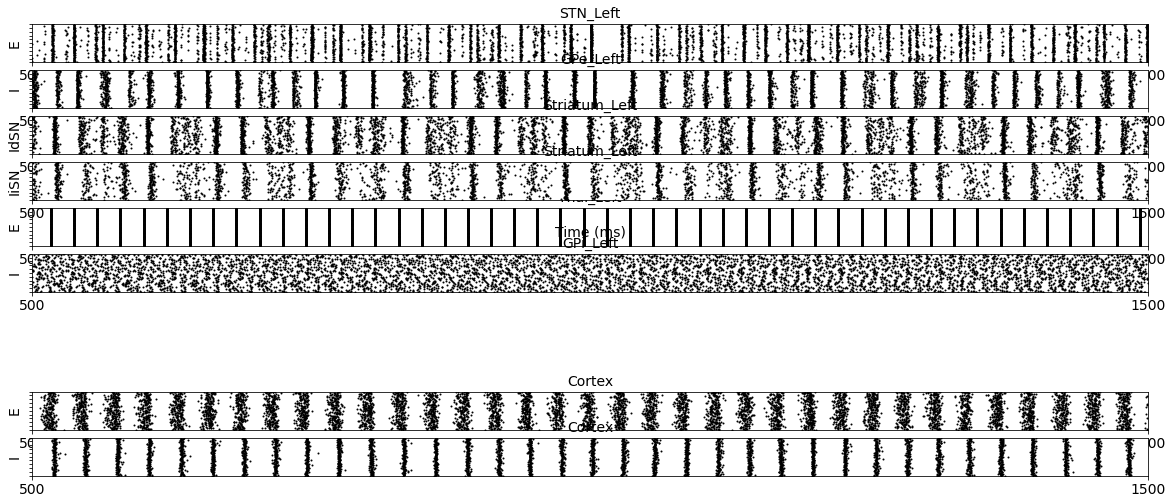

<Figure size 432x288 with 0 Axes>

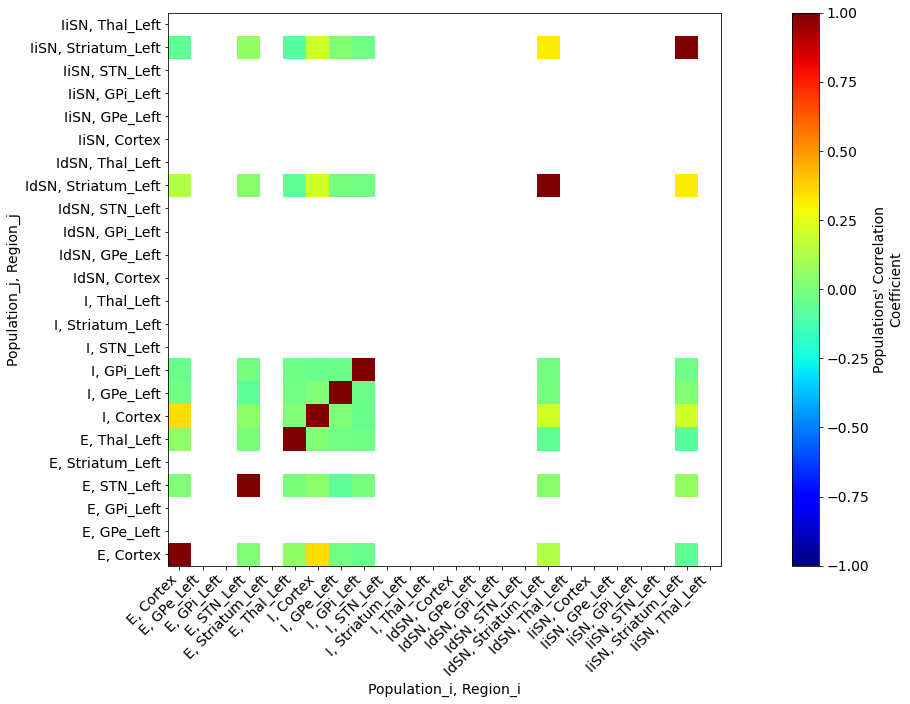

In [13]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.config.FONTSIZE = 14 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
        plotter.plot_spike_events(spikes_res["spikes"], mean_rates=spikes_res["mean_rate"], # rates=spikes_res["mean_rate_time_series"], 
                                  spikes_markersize=1.0, figsize=FIGSIZE, 
                                  n_time_ticks=2, show_time_axis=True, 
                                  time_axis_min=transient, time_axis_max=simulation_length
                                 ) # 
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [14]:
print("Mean spike rates:")
for pop in spikes_res["mean_rate"].coords["Population"]:
    for reg in spikes_res["mean_rate"].coords["Region"]:
        if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
            print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                   spikes_res["mean_rate"].loc[pop, reg].values.item()))


Mean spike rates:
E - Cortex: 12.364
E - STN_Left: 31.1512
E - Thal_Left: 48.048
I - Cortex: 32.7928
I - GPe_Left: 33.1281
I - GPi_Left: 33.3133
IdSN - Striatum_Left: 32.0771
IiSN - Striatum_Left: 18.5736


In [15]:
spikes_res["mean_rate"][0]

<xarray.DataArray "Mean Populations' Spikes' Rates" (Region: 6)>
array([12.36403067,         nan,         nan, 31.15115109,         nan,
       48.04804795])
Coordinates:
  * Region      (Region) object 'Cortex' 'GPe_Left' ... 'Thal_Left'
    Population  <U1 'E'

In [16]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion(data=spikes_res["mean_rate_time_series"]._data,
                                            connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");
    

### Get  SpikingNetwork mean field variable time series and plot them

2022-10-21 17:09:27,847 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model  for  created!
2022-10-21 17:09:27,847 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model  for  created!
2022-10-21 17:09:27,855 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model  for  created!
2022-10-21 17:09:27,855 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model  for  created!


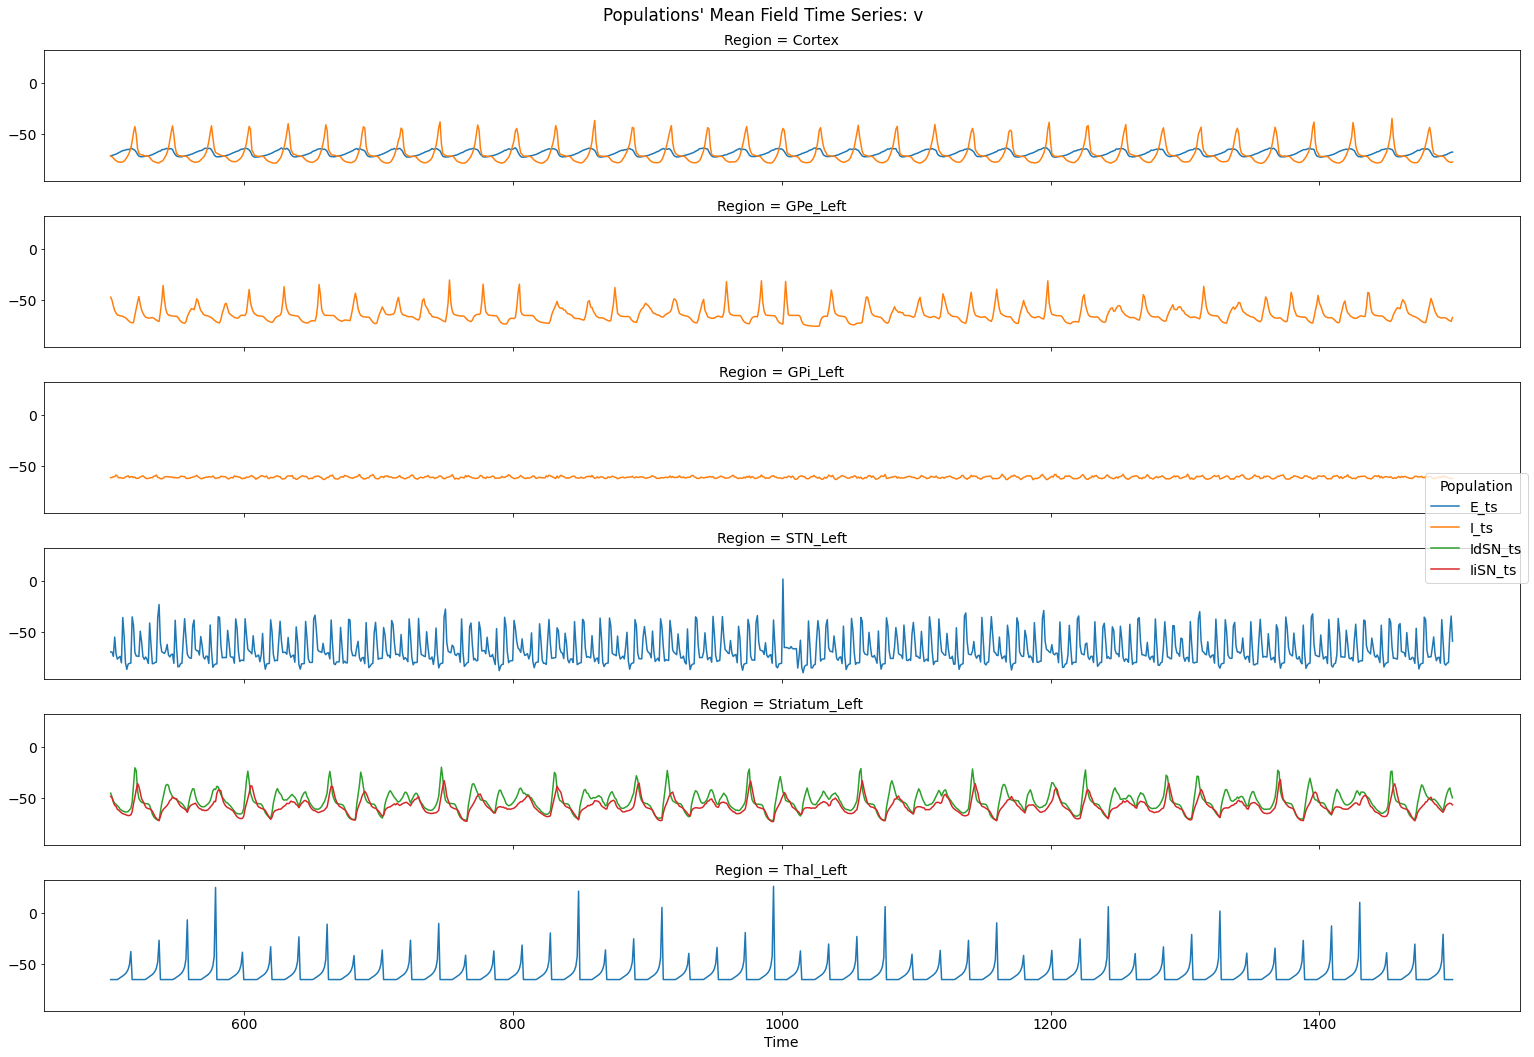

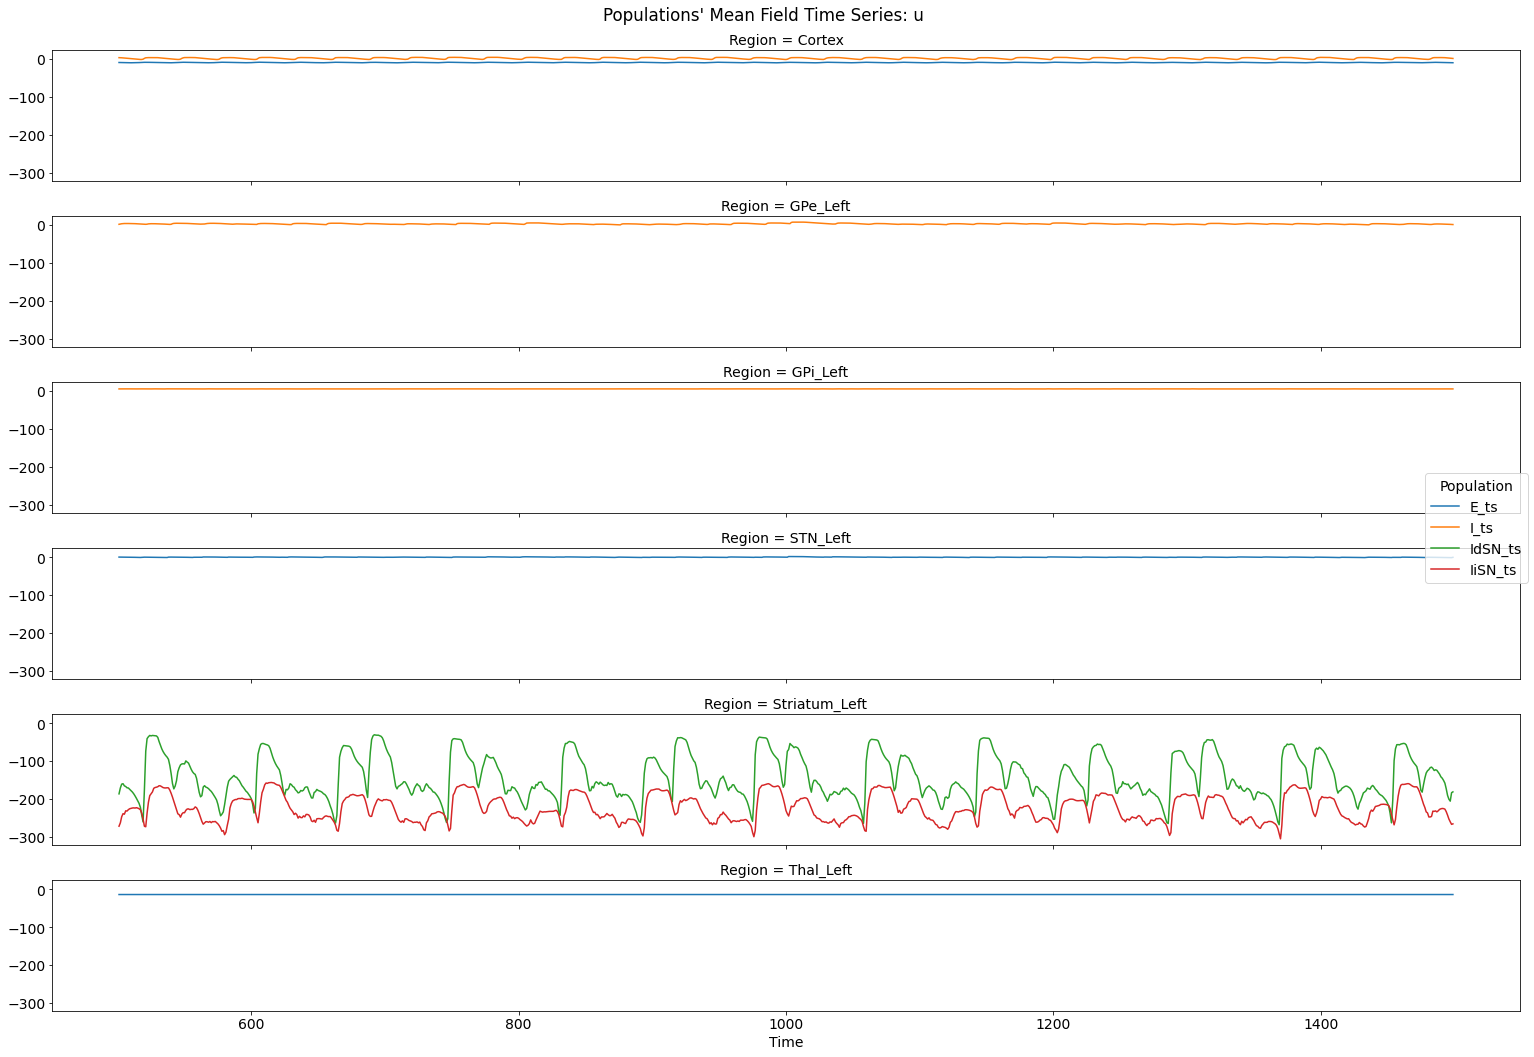

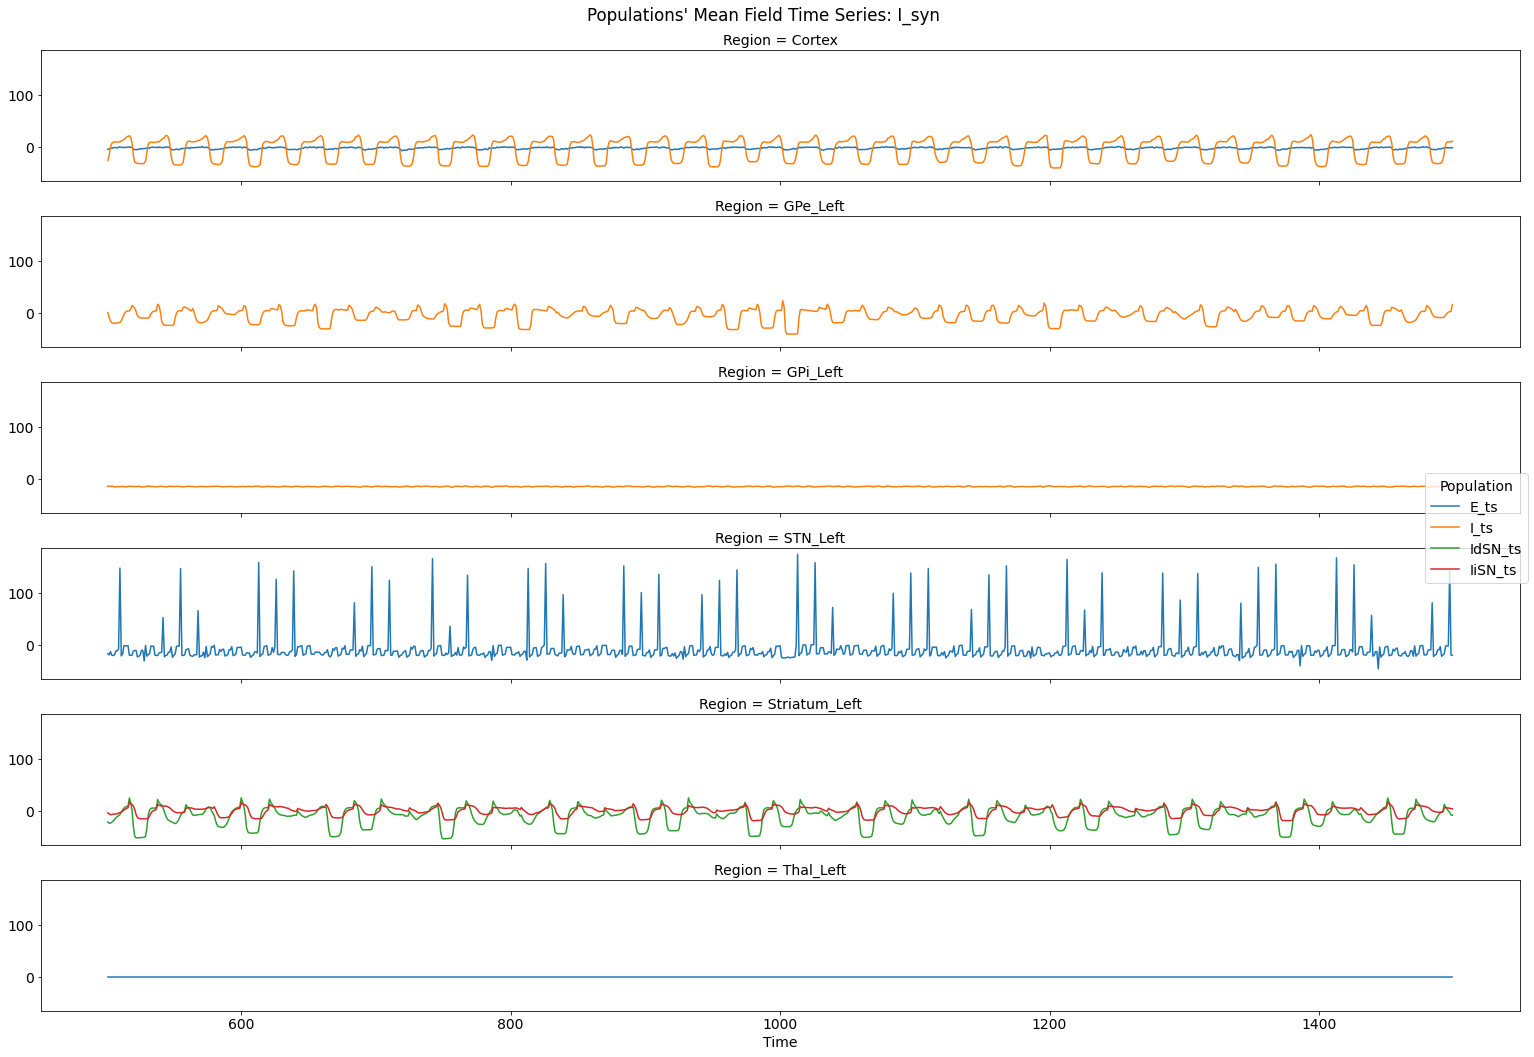

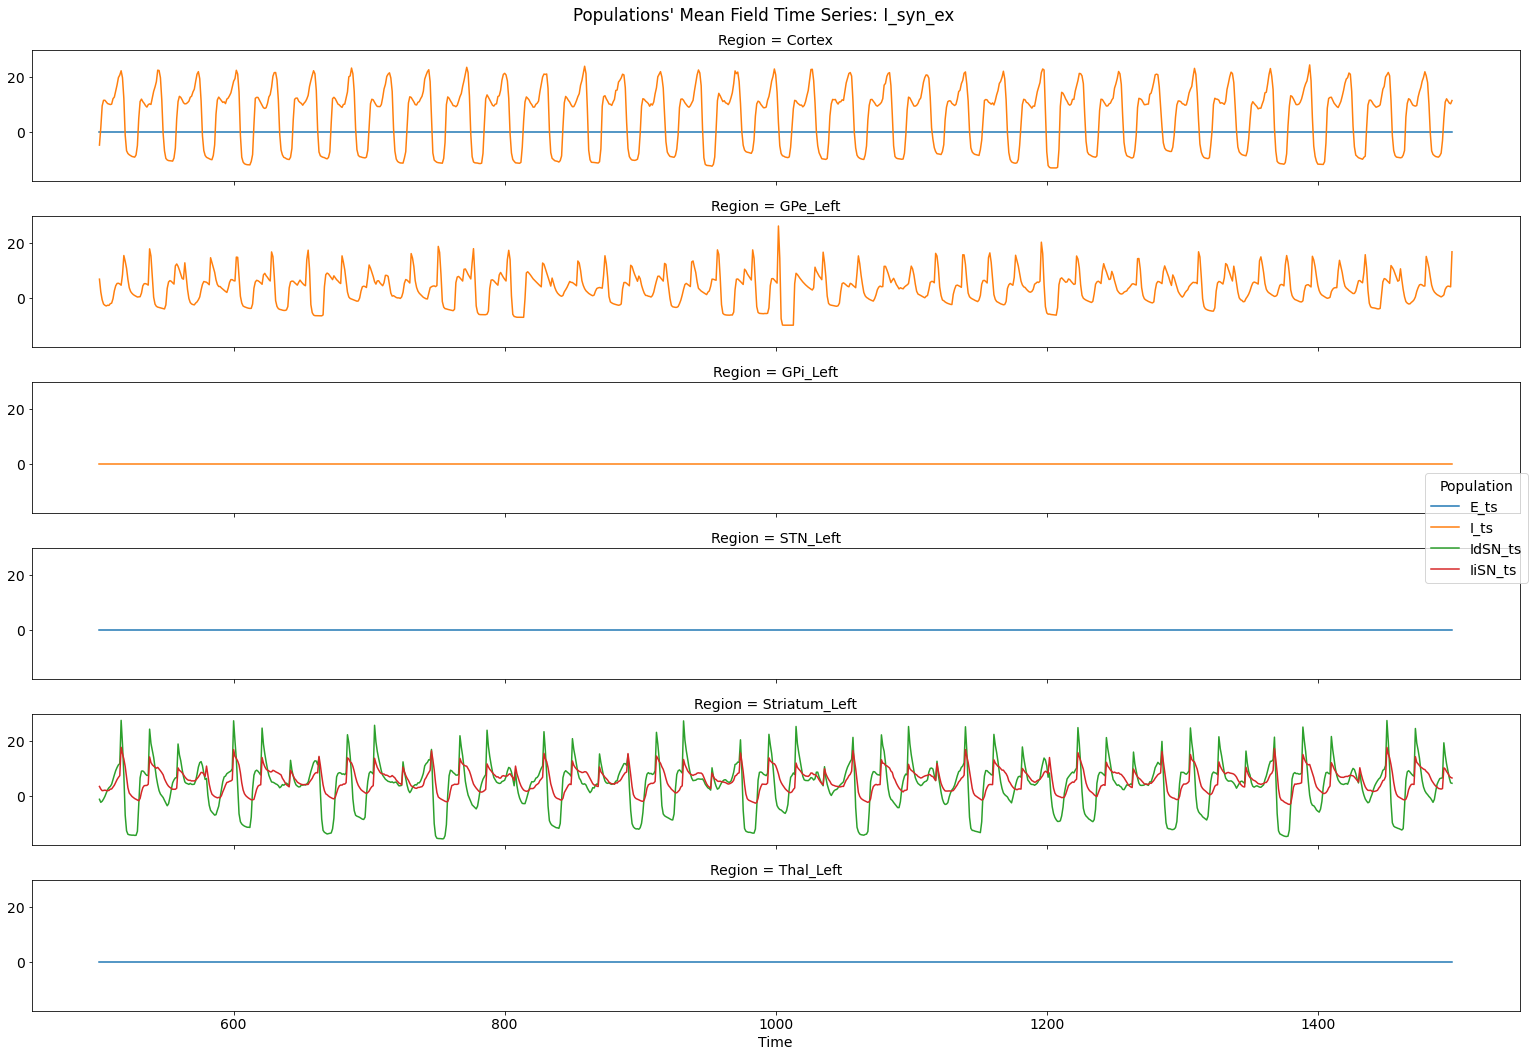

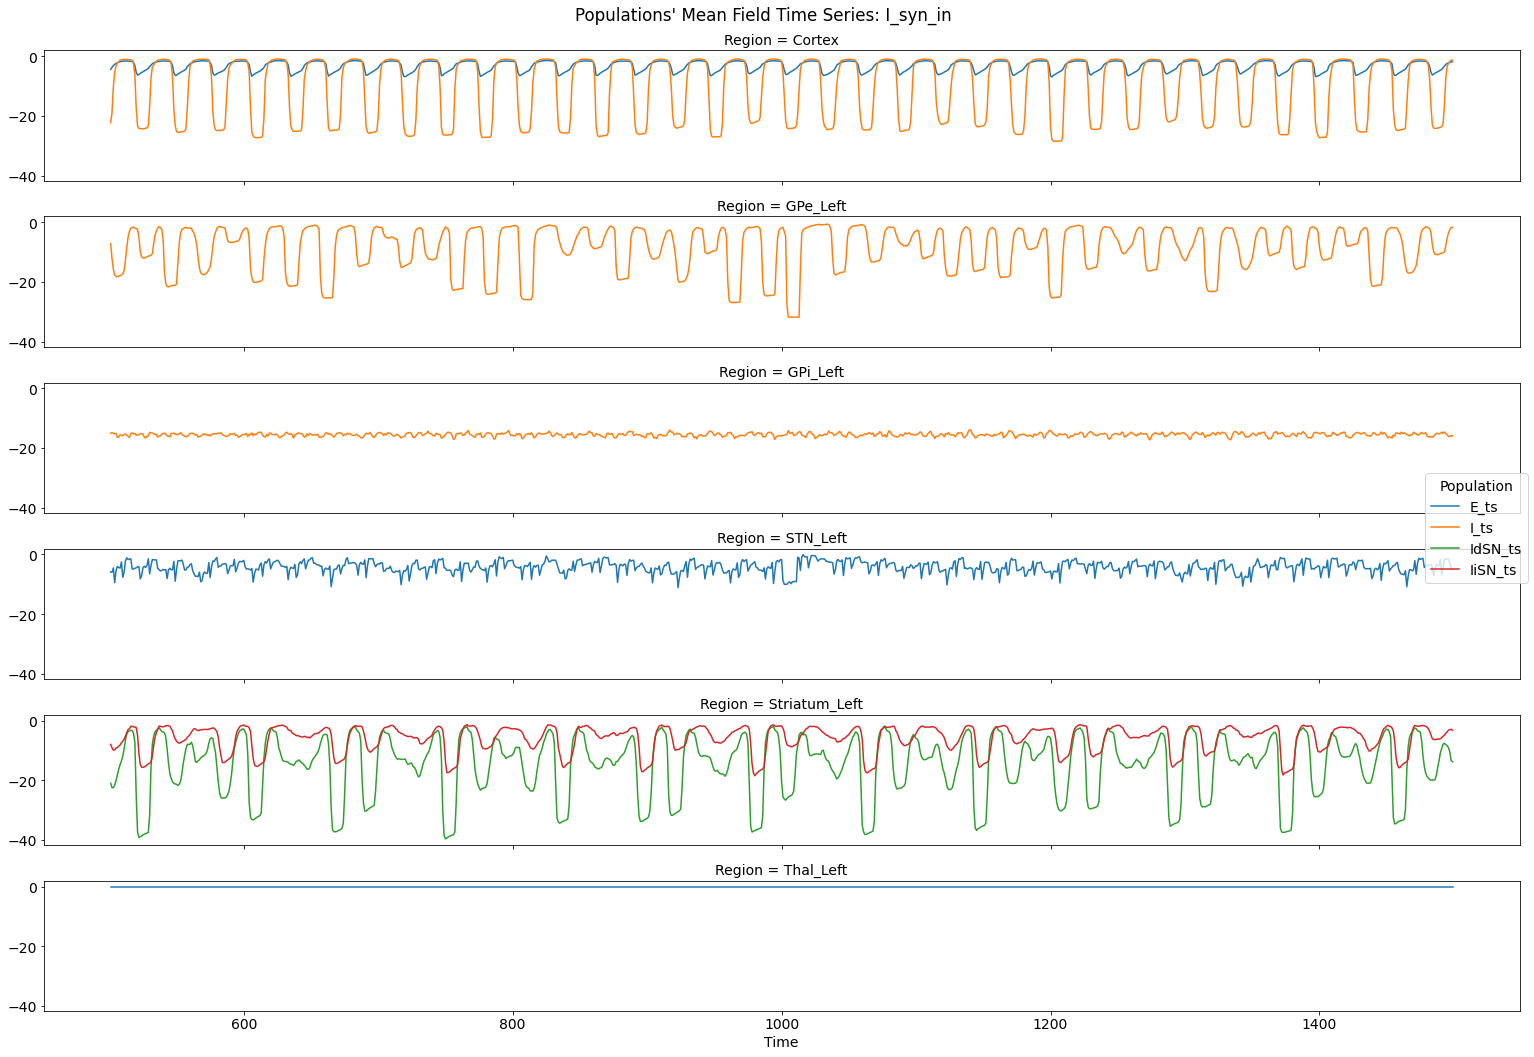

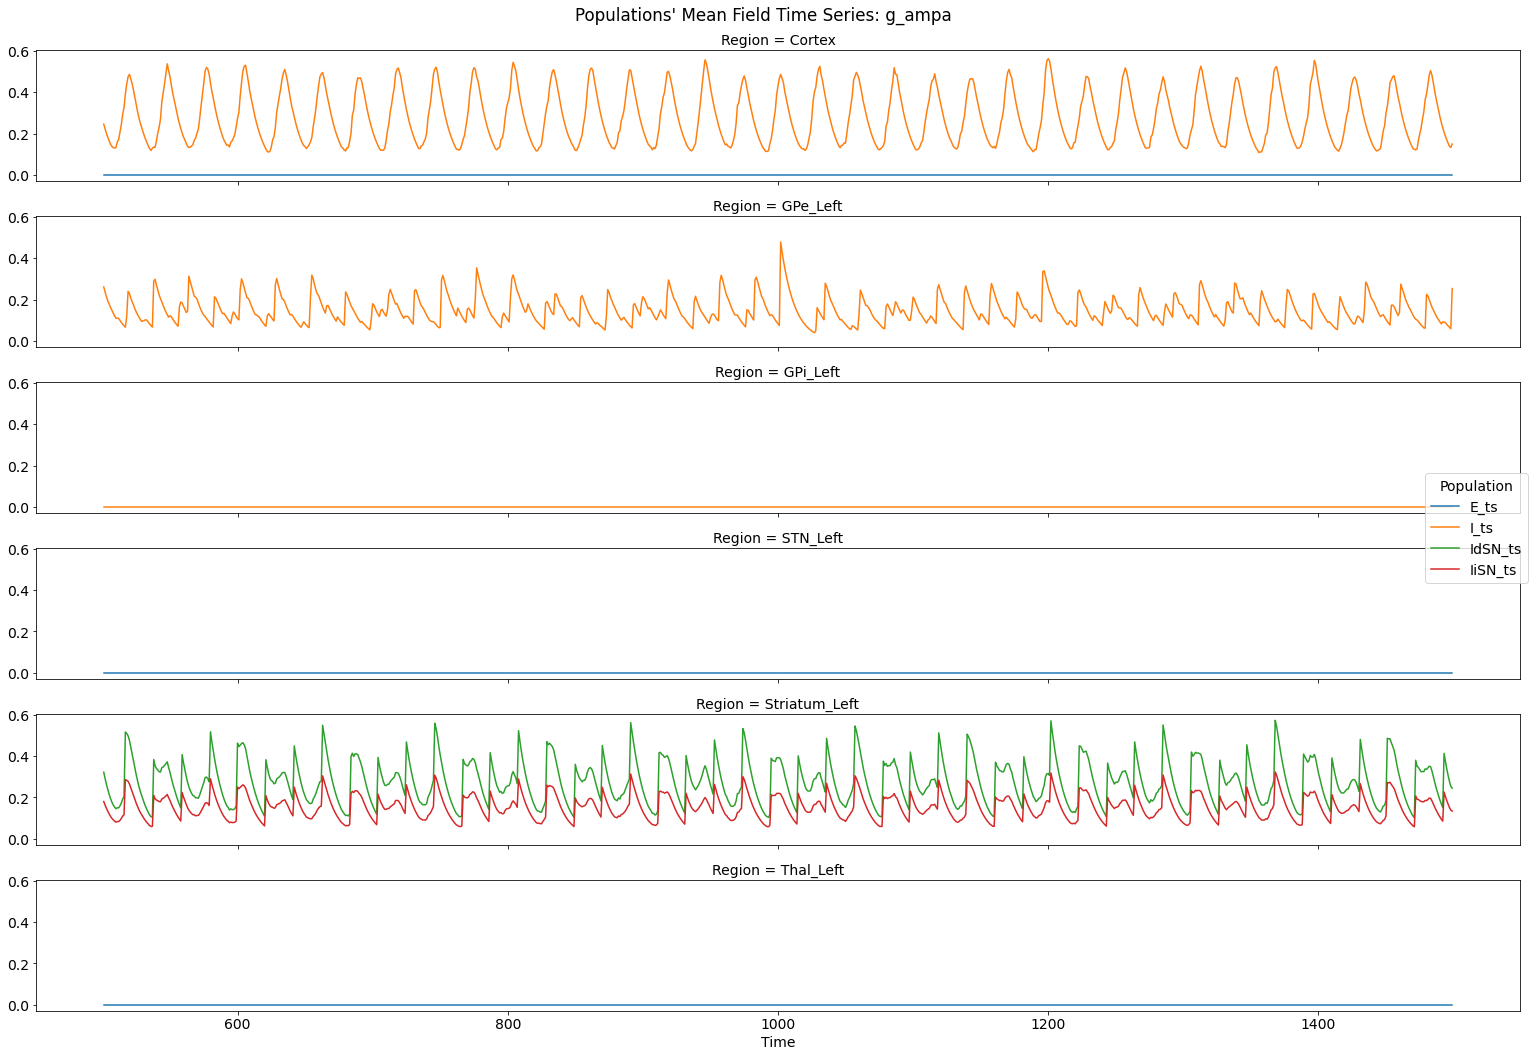

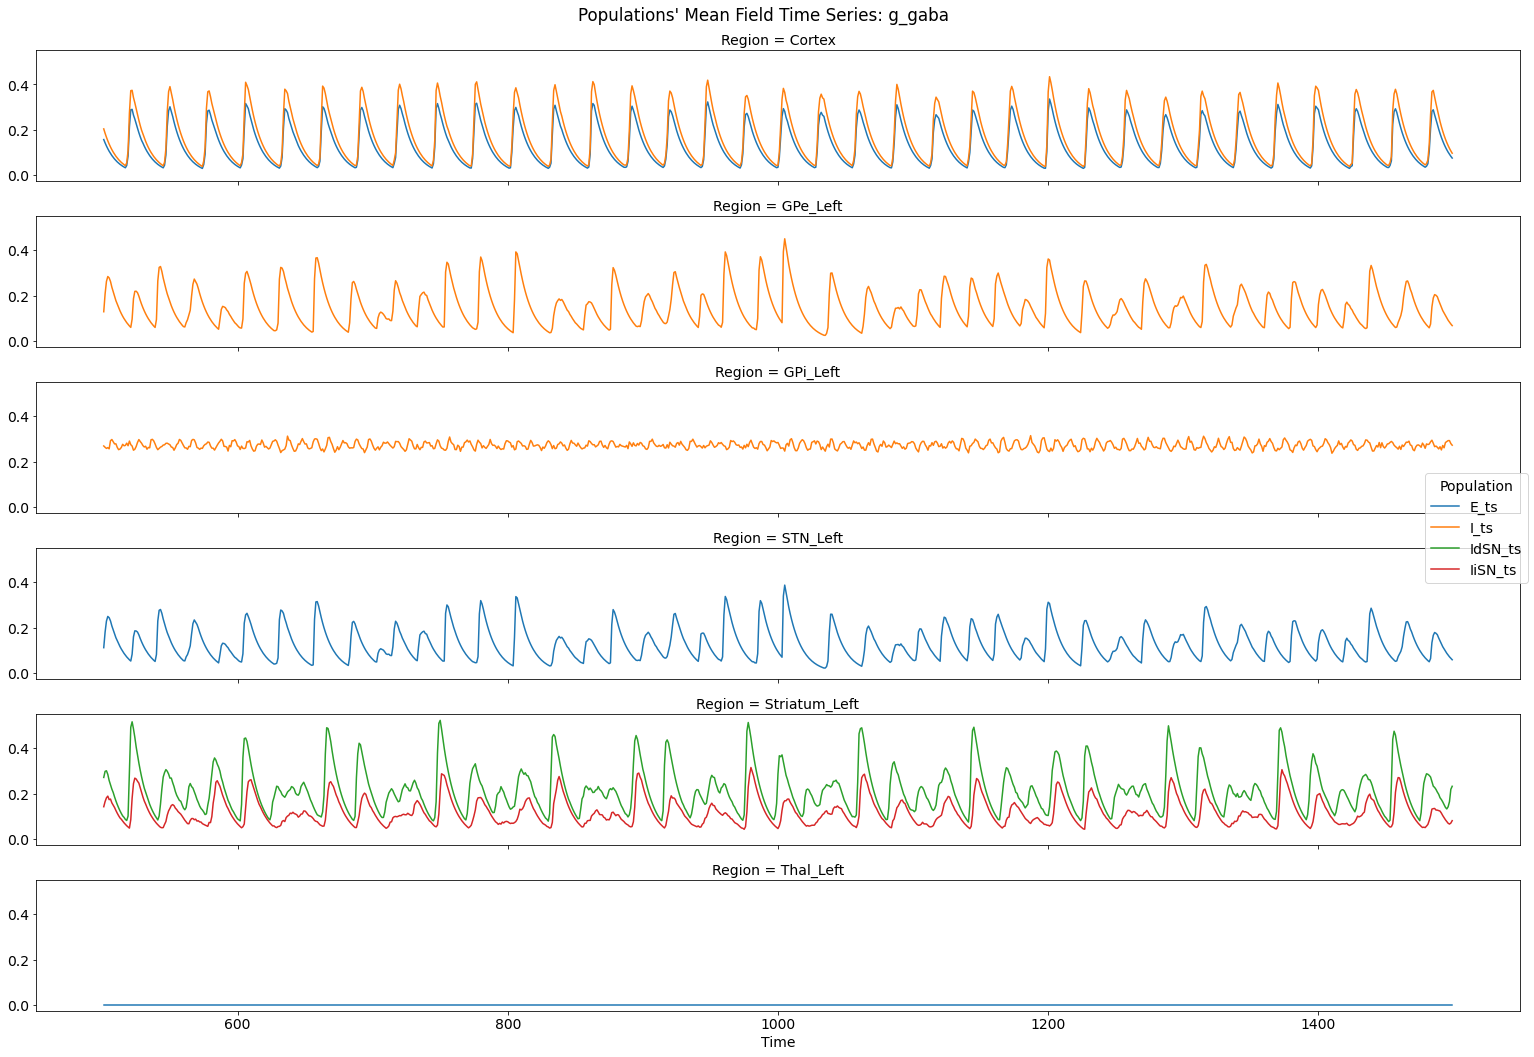

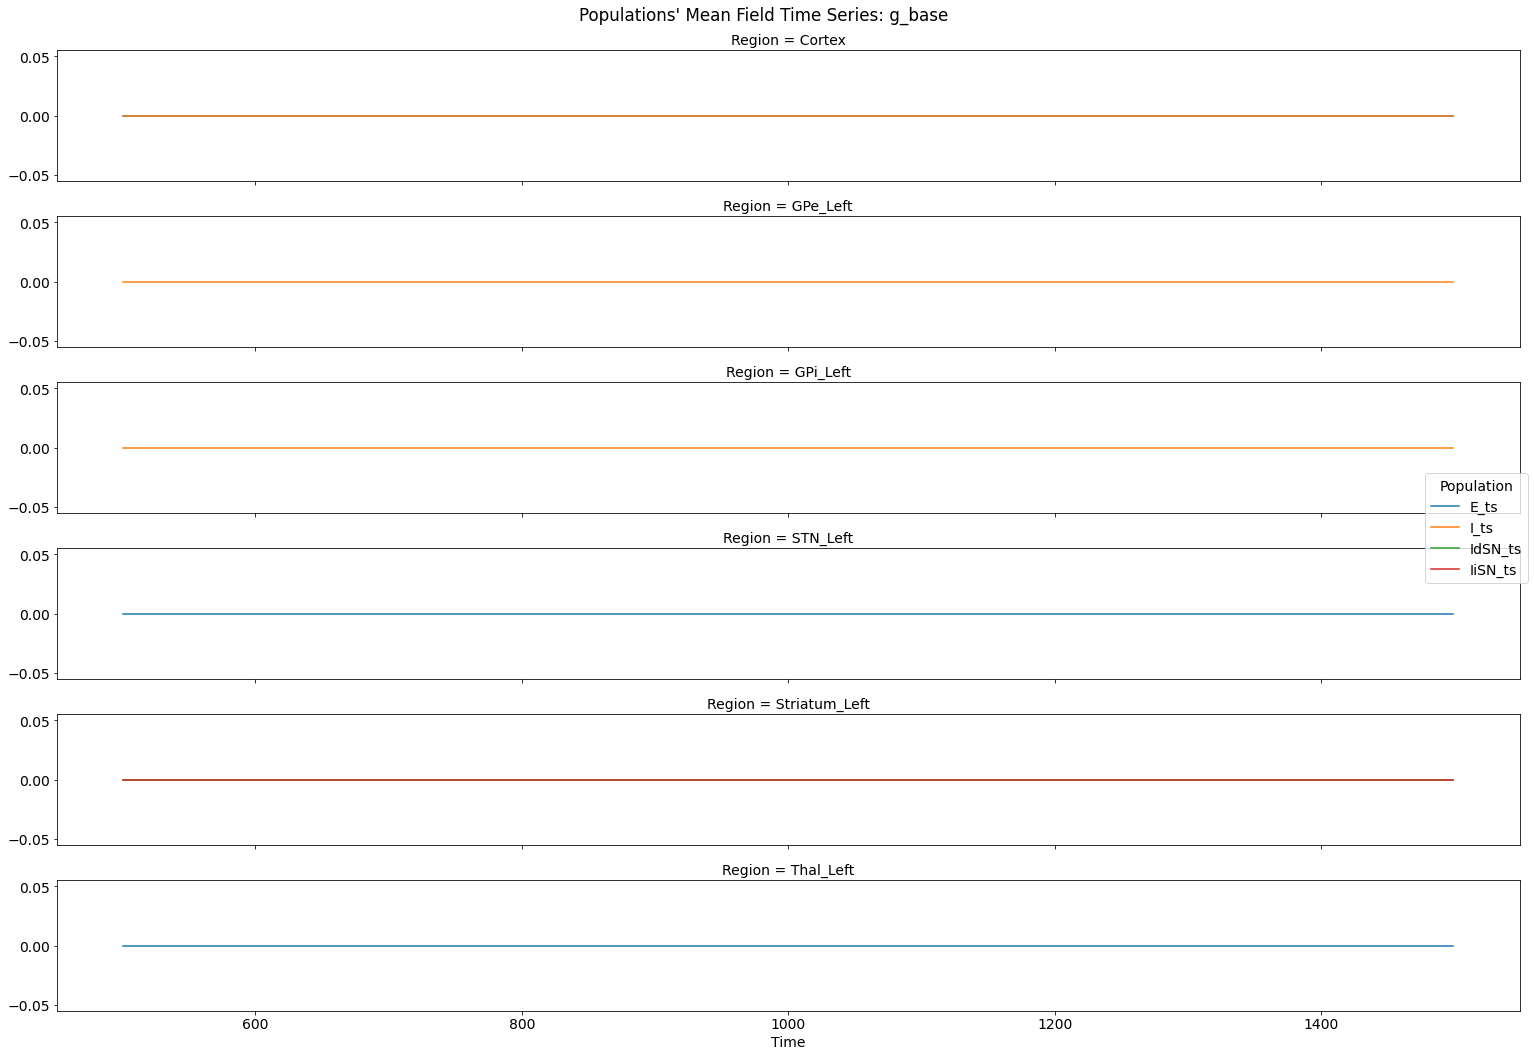

In [17]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [18]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion(data=mean_field_ts._data,
                                            connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [19]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [20]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Vitay J, Dinkelbach HÜ and Hamker FH (2015). <br>
  ANNarchy: a code generation approach to neural simulations on parallel hardware. <br>
  Frontiers in Neuroinformatics 9:19. doi:10.3389/fninf.2015.00019 <br>
  For more details see https://annarchy.readthedocs.io/en/latest/ <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868

In [21]:
# ann_model_builder.populations
names = ["GPe", "GPi", "STN", "dSN", "iSN", "Thal", "CtxE", "CtxI"]
for iP, (name, pop) in enumerate(zip(names, ann_network.annarchy_instance.Global._network[0]["populations"])):
    print("\n%s - %s (size = %d): params =\n%s" % (pop.name, name, pop.size, pop.init) )


I - GPe (size = 200): params =
{'a': 0.005, 'b': 0.585, 'c': -65.0, 'd': 4.0, 'n0': 140.0, 'n1': 5.0, 'n2': 0.04, 'I': 12.0, 'tau_refrac': 10.0, 'tau_ampa': 10.0, 'tau_gaba': 10.0, 'E_ampa': 0.0, 'E_gaba': -90.0, 'tau_syn': 1.0, 'C': 1.0, 'v_th': 30.0, 'Vr': 0.0, 'noise': 0.0, 'I_syn_ex': 0.0, 'I_syn_in': 0.0, 'I_syn': 0.0, 'g_base': 0.0, 'g_ampa': 0.0, 'g_gaba': 0.0, 'v': -70.0, 'u': -18.55, 'r': 0.0, 'g_dbs': 0.0, 'g_exc': 0.0}

I - GPi (size = 200): params =
{'a': 0.005, 'b': 0.585, 'c': -65.0, 'd': 4.0, 'n0': 140.0, 'n1': 5.0, 'n2': 0.04, 'I': 30.0, 'tau_refrac': 10.0, 'tau_ampa': 10.0, 'tau_gaba': 10.0, 'E_ampa': 0.0, 'E_gaba': -90.0, 'tau_syn': 1.0, 'C': 1.0, 'v_th': 30.0, 'Vr': 0.0, 'noise': 0.0, 'I_syn_ex': 0.0, 'I_syn_in': 0.0, 'I_syn': 0.0, 'g_base': 0.0, 'g_ampa': 0.0, 'g_gaba': 0.0, 'v': -70.0, 'u': -18.55, 'r': 0.0, 'g_dbs': 0.0, 'g_exc': 0.0}

E - STN (size = 200): params =
{'a': 0.005, 'b': 0.265, 'c': -65.0, 'd': 2.0, 'n0': 140.0, 'n1': 5.0, 'n2': 0.04, 'I': 3.0, 'tau_

In [22]:
# for reg in ann_network.brain_regions:
#     for pop in reg:
#         conns = pop.GetFromConnections("w")
#         print("%s-%s:" % (reg.label, pop.label))
#         for conn in conns:
#             print("%s" % str(conn))

In [23]:
print("Configured connections:")

print("\nWithin node's connections:")
ncons = 0
for pop in ann_model_builder.populations_connections:
    ncons += 1
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["nodes"])
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["probability"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%d. %s -> %s (%s) = %g (p=%g): %s (%g, %g)" 
          % (ncons, pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))
    
print("\nAmong node's connections:")
for pop in ann_model_builder.nodes_connections:
    ncons += 1 
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["source_nodes"], pop["target_nodes"]).item()
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["probability"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%d. %s -> %s (%s) = %g (p=%g): %s (%g, %g)" 
          % (ncons, pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))
    
print("\nEffective connections:")
conns = ["CtxICtxI", "GPeGPe", "GPiGPi", "dSNdSN", "iSNiSN", "CtxECtxI", "CtxICtxE", 
         "dSNGPi" , "iSNGPe", "GPeGPi", "GPiThal", "GPeSTN", "ThaldSN", "ThaliSN", 
         "STNGPe", "STNGPi", "CtxThal", "CtxSTN", "CtxdSN", "CtxiSN"]
for iC, (name, proj) in enumerate(zip(conns, 
                                      ann_network.annarchy_instance.Global._network[0]["projections"])):
    meanNconns = np.mean([len(d.pre_ranks) for d in proj.dendrites])
    p = meanNconns / proj.pre.size
    print("%d. %s: %s w = %g (%g) (%s), effective_probability = %g (%g)" % 
          (iC+1, proj.name, name, proj.w, loadedParams["%s_weights" % name], proj.target,
            p, loadedParams["%s_probs" % name]))  # meanNconns = %g,  meanNconns,

Configured connections:

Within node's connections:
1. I -> I (gaba) = 0.00970393 (p=0.337033): CtxICtxI (0.00970393, 0.337033)
2. I -> I (gaba) = 0.00676563 (p=0.323254): GPeGPe (0.00676563, 0.323254)
3. I -> I (gaba) = 0.0121607 (p=0.337174): GPiGPi (0.0121607, 0.337174)
4. IdSN -> IdSN (gaba) = 0.0076305 (p=0.434551): dSNdSN (0.0076305, 0.434551)
5. IiSN -> IiSN (gaba) = 0.0141185 (p=0.223545): iSNiSN (0.0141185, 0.223545)
6. E -> I (ampa) = 0.00912789 (p=0.408599): CtxECtxI (0.00912789, 0.408599)
7. I -> E (gaba) = 0.0118726 (p=0.213091): CtxICtxE (0.0118726, 0.213091)

Among node's connections:
8. IdSN -> I (gaba) = 0 (p=0.178595): CtxThal (0, 1)
9. IiSN -> I (gaba) = 0 (p=0.335189): CtxThal (0, 1)
10. I -> I (gaba) = 0 (p=0.325257): CtxThal (0, 1)
11. I -> E (gaba) = 0 (p=0.245789): CtxThal (0, 1)
12. I -> E (gaba) = 0.0112597 (p=0.165056): STNGPe (0.0112597, 0.396223)
13. E -> IdSN (ampa) = 0.0120699 (p=0.120551): ThaldSN (0.0120699, 0.120551)
14. E -> IiSN (ampa) = 0.00599236 (